In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `~/Dropbox/Presentations/2020-detroit-tech-watch-julia-intro/Project.toml`


# Intro to Julia

## Robin Deits
### Detroit Tech Watch
### May 26, 2020

Follow along at: https://tinyurl.com/tech-watch-julia [1]

[1] https://github.com/rdeits/DetroitTechWatch2020.jl/blob/master/Intro%20to%20Julia.ipynb

# Who am I?

* Former MIT PhD, now a robotics engineer at Boston Dynamics
    * The opinions expressed here are mine, not those of Boston Dynamics
* Long-time Julia user:
    * Co-founder of JuliaRobotics: https://juliarobotics.org/
    * JuliaCon presenter: https://www.youtube.com/watch?v=dmWQtI3DFFo
    * Open-source contributor: https://github.com/rdeits/
 
<figure>
    <img src="img/atlas.gif" width="500px"/>
    <figcaption>My day job</figcaption>
</figure>



# Overview

* What is Julia?
* Tour of Julia
  * Functions, types, multiple dispatch
* Julia is fast! 
  * Benchmarking Julia vs. C and Python
* Bonus Features of Julia
  * Async tasks, multiprocessing, and metaprogramming
* What's hard to do in Julia?
* Essential Julia packages and tools

# What is Julia

<https://docs.julialang.org/en/v1/>

* Julia is a high-level language like Python with the performance of a fast language like C
* Julia is a great choice for scientific computing, with:
  * Excellent performance
  * N-dimensional arrays
  * Parallel and distributed computing
* And it's also a nice environment for general purpose programming, with:
  * An active ecosystem of packages and good tools for managing them
  * A rich type system
  * Iterators, asynchronous tasks, and coroutines


# Julia at a Glance

* First public release in 2012, version 1.0 released in 2018
* Free
    * Julia itself is BSD licensed
    * It bundles some GPLed libraries (which can be disabled if desired)
* Built-in JIT compiler transforms Julia code to native assembly at run time
  * Uses LLVM under the hood
* Garbage collected
* Dynamically typed
* Organized via multiple dispatch

# A Tour of Julia

##  The Basics

Arithmetic:

In [2]:
2 + 2

4

Strings:

In [3]:
# Strings
println("hello world")

hello world


Arrays:

In [4]:
x = [1, 2, 3, 4];

## Functions

In [5]:
function say_hello(name)
    println("hello ", name)
end

say_hello (generic function with 1 method)

In [6]:
say_hello("world")

hello world


By default, a function is generic, so you can pass in any type you want:

In [7]:
say_hello([1, 2, 3])

hello [1, 2, 3]


## Types

Every value in Julia has a type:

In [8]:
typeof(1.0)

Float64

In [9]:
typeof(1)

Int64

In [10]:
typeof(π)

Irrational{:π}

In [11]:
typeof([1, 2, 3])

Array{Int64,1}

You can create your own types to organize your data:

In [12]:
struct Person
  name::String
end

alice = Person("Alice")

Person("Alice")

Julia's types are extremely lightweight, and user-defined types are *exactly* as performant as anything built-in:

In [13]:
sizeof(Person) == sizeof(Ptr{String})

true

## Multiple Dispatch

Julia does not have classes like Java, Python, or C++. Instead, code is organized around *multiple dispatch*, where the compiler chooses the appropriate method of a given function based on the types of *all* of its input arguments. 

For more, see: [The Unreasonable Effectiveness of Multiple Dispatch (Stefan Karpinski, JuliaCon 2019)](https://www.youtube.com/watch?v=kc9HwsxE1OY)

In [14]:
greet(x, y) = println("$x greets $y")

greet (generic function with 1 method)

In [15]:
alice = Person("alice")
bob = Person("bob")

greet(alice, bob)

Person("alice") greets Person("bob")


Currently there is only one `greet()` function, and it will work on `x` and `y` of any type:

In [16]:
greet([1, 2, 3], "hello world")

[1, 2, 3] greets hello world


We can use abstract types to organize the behavior of related types:

In [17]:
abstract type Animal end

struct Cat <: Animal
    name::String
end

We've already defined `greet(x, y)` for any `x` and `y`, but we can add another definition for a more specific set of input types.

We can be as specific or as general as we like with the argument types:

In [18]:
greet(x::Person, y::Animal) = println("$x pats $y")

greet (generic function with 2 methods)

In [19]:
greet(x::Cat, y) = println("$x meows at $y")

greet (generic function with 3 methods)

Julia will always pick the *most specific* method that matches the provided function arguments.

In [20]:
fluffy = Cat("fluffy")

greet(alice, fluffy)

Person("alice") pats Cat("fluffy")


In [21]:
greet(fluffy, alice)

Cat("fluffy") meows at Person("alice")


In [22]:
struct Dog <: Animal
    name::String
end

greet(x::Dog, y) = println("$x barks at $y")

greet(x::Dog, y::Person) = println("$x licks $y's face")

greet(x::Dog, y::Dog) = println("$x sniffs $y's butt")

greet (generic function with 6 methods)

In [23]:
fido = Dog("fido")
rex = Dog("rex")

greet(alice, fido)

Person("alice") pats Dog("fido")


In [24]:
greet(fido, fluffy)

Dog("fido") barks at Cat("fluffy")


In [25]:
greet(fido, bob)

Dog("fido") licks Person("bob")'s face


In [26]:
greet(fido, rex)

Dog("fido") sniffs Dog("rex")'s butt


If you want to know which `greet` method will be called for a given set of arguments, you can use `@which` to check:

In [27]:
@which greet(alice, fido)

greet(x::Person, y::Animal) in Main at In[18]:1

You can list all of the methods of a given function with `methods`:

In [28]:
methods(greet)

# 6 methods for generic function "greet":
[1] greet(x::Dog, y::Dog) in Main at In[22]:9
[2] greet(x::Dog, y::Person) in Main at In[22]:7
[3] greet(x::Person, y::Animal) in Main at In[18]:1
[4] greet(x::Cat, y) in Main at In[19]:1
[5] greet(x::Dog, y) in Main at In[22]:5
[6] greet(x, y) in Main at In[14]:1

## Modules

Modules in Julia are used to organize code into namespaces.

In [29]:
module MyUsefulModule

export hello

hello() = println("hello world")
goodbye() = println("goodbye world")

end

MyUsefulModule.hello()

hello world


The `using` command brings any `export`ed symbols from a module into the current namespace:

In [30]:
using .MyUsefulModule
hello()

hello world


## Using Packages

Julia has a built-in package manager called `Pkg`. It handles installing packages and managing all your package environments. 

A package *environment* represents a single set of installed packages. Let's activate the environment for this talk:

In [31]:
using Pkg
Pkg.activate(".")

 Activating environment at `~/Dropbox/Presentations/2020-detroit-tech-watch-julia-intro/Project.toml`


(this is similar to `source venv/bin/activate` in a Python virtual environment)

We can install a package in our current environment. This will only affect that environment, so we can safely do this without breaking any other Julia projects we might be working on:

In [32]:
Pkg.add("Colors")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `git@github.com:JuliaRegistries/General.git`


  Resolving package versions...
   Updating `~/Dropbox/Presentations/2020-detroit-tech-watch-julia-intro/Project.toml`
 [no changes]
   Updating `~/Dropbox/Presentations/2020-detroit-tech-watch-julia-intro/Manifest.toml`
 [no changes]


The `Project.toml` file gives a concise description of the packages we've added to this environment:

In [33]:
run(`cat Project.toml`)

[deps]
BenchmarkTools = "6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf"
Colors = "5ae59095-9a9b-59fe-a467-6f913c188581"
HTTP = "cd3eb016-35fb-5094-929b-558a96fad6f3"
Plots = "91a5bcdd-55d7-5caf-9e0b-520d859cae80"
ProgressMeter = "92933f4c-e287-5a05-a399-4b506db050ca"
PyCall = "438e738f-606a-5dbb-bf0a-cddfbfd45ab0"


Process(`cat Project.toml`, ProcessExited(0))

The package manager also generates a complete manifest of every package that is installed, including all the transitive dependencies and their versions. You can use this to reproduce a given package environment exactly:

In [34]:
run(`cat Manifest.toml`)

# This file is machine-generated - editing it directly is not advised

[[Base64]]
uuid = "2a0f44e3-6c83-55bd-87e4-b1978d98bd5f"

[[BenchmarkTools]]
deps = ["JSON", "Logging", "Printf", "Statistics", "UUIDs"]
git-tree-sha1 = "9e62e66db34540a0c919d72172cc2f642ac71260"
uuid = "6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf"
version = "0.5.0"

[[Bzip2_jll]]
deps = ["Libdl", "Pkg"]
git-tree-sha1 = "3663bfffede2ef41358b6fc2e1d8a6d50b3c3904"
uuid = "6e34b625-4abd-537c-b88f-471c36dfa7a0"
version = "1.0.6+2"

[[ColorSchemes]]
deps = ["ColorTypes", "Colors", "FixedPointNumbers", "Random", "StaticArrays"]
git-tree-sha1 = "7a15e3690529fd1042f0ab954dff7445b1efc8a5"
uuid = "35d6a980-a343-548e-a6ea-1d62b119f2f4"
version = "3.9.0"

[[ColorTypes]]
deps = ["FixedPointNumbers", "Random"]
git-tree-sha1 = "c73d9cfc2a9d8433dc77f5bff4bddf46b1d78c20"
uuid = "3da002f7-5984-5a60-b8a6-cbb66c0b333f"
version = "0.10.3"

[[Colors]]
deps = ["ColorTypes", "FixedPointNumbers", "InteractiveUtils", "Reexport"]
git-tree-sha1 = "2f

Process(`cat Manifest.toml`, ProcessExited(0))

## Example: Representing Colors and Images with Colors.jl

Let's take a tour of one of my favorite packages, Colors.jl, and show off some feature's of Julia's arrays along the way. 

We can load a package from the current environment with `using`:

In [35]:
using Colors: RGB  # For now, just bring the `RGB` name into scope

In [36]:
RGB(1, 0, 0)

The `RGB` type from Colors.jl knows how to render itself as an actual colored `div` when running in Jupyter. We can also print its value as a string if we want:

In [37]:
print(RGB(1, 0, 0))

RGB{N0f8}(1.0,0.0,0.0)

Julia arrays are fully generic, so we can create an array of colors:

In [38]:
C = [RGB(i, j, 0) for i in 0:0.1:1, j in 0:0.1:1]

In [39]:
typeof(C)

Array{RGB{Float64},2}

C is an array like any other, so we can index into it and slice it:

In [40]:
C[8, 2]

In [41]:
C[1, :]

Let's pull out the red channel from our image `C`:

In [42]:
using Colors: red, green, blue

If you don't know what a function does, you can use the `?` operator to access its docstring:

In [43]:
?red

search: reduce redisplay redirect_stdin redirect_stdout redirect_stderr



`red(c)` returns the red component of an `AbstractRGB` opaque or transparent color.


In [44]:
red(C[1, 1])

0.0

### Broadcasting

To get the red channel of each element of `C`, we can use *broadcasting*. The syntax `f.(x)` applies the function `f` to each element of `x`:

In [45]:
red.(C)

11×11 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3
 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6
 0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7
 0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

That's not very visual. Let's render that red channel as a grayscale image:

In [46]:
using Colors: Gray

Gray.(red.(C))

Julia's broadcasting provides guaranteed *loop fusion*. That means that if you do `Gray.(red.(x))`, the language guarantees that it will do only one loop over the elements of `x`, computing `Gray(red(x_i))` for each `x_i` in `x`. 

See https://julialang.org/blog/2017/01/moredots/ for more. 

# Julia is Fast

* I claimed at the beginning of this talk that Julia has performance on par with C. Let's prove it!
* To show this, I'll implement the basic `sum` function in Julia, C, and Python so we can compare them:

Let's start with Julia:

In [47]:
"""
Naive implementation of sum. Works for any iterable `x` with any element type.
"""
function my_sum(x)
    result = zero(eltype(x))
    for element in x
        result += element
    end
    return result
end

my_sum

And let's create some data to test with:

In [48]:
data = rand(Float64, 10^7)

10000000-element Array{Float64,1}:
 0.3250821881143635
 0.5739150786758722
 0.13383939143899348
 0.4395993297446783
 0.3295526596520042
 0.02847425323560948
 0.8487199564066177
 0.7997505161145844
 0.6245936015647562
 0.5106550585869152
 0.9238301866509853
 0.49764889129935574
 0.7401243526305121
 ⋮
 0.6680583163473712
 0.4697749293985751
 0.8080600012381363
 0.08649714310431955
 0.2412430060343358
 0.33645492148197076
 0.138424161003317
 0.27552196839070064
 0.00438248390256013
 0.7495825118700372
 0.11786299612959139
 0.9934003189851528

To measure the performance of `my_sum`, we'll use the BenchmarkTools.jl package. 

In [49]:
using BenchmarkTools

In [50]:
@benchmark my_sum($data)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.994 ms (0.00% GC)
  median time:      12.054 ms (0.00% GC)
  mean time:        12.099 ms (0.00% GC)
  maximum time:     16.589 ms (0.00% GC)
  --------------
  samples:          414
  evals/sample:     1

In this case, we only care about the minimum time. The `@btime` macro is a shorthand to print just that minimum time:

In [51]:
@btime my_sum($data)

  11.716 ms (0 allocations: 0 bytes)


4.998996907719521e6

Let's compare this with C. It's easy to call functions from C shared libraries in Julia:

In [52]:
"""
Call the `strcmp` function from `libc.so.6`
"""
function c_compare(x::String, y::String)
    # We have to tell the compiler that this C function returns an `int` and 
    # expects two `char *` inputs. The `Cint` and `Cstring` types are convenient
    # shorthands for those:
    ccall((:strcmp, "libc.so.6"), Cint, (Cstring, Cstring), x, y)
end

c_compare

In [53]:
c_compare("hello", "hello")

0

Calling C functions has very little overhead:

In [54]:
@btime c_compare($("hello"), $("hello"))

  8.760 ns (0 allocations: 0 bytes)


0

Let's create a C implementation of `my_sum`. We can do that without leaving Julia by piping some code directly to GCC:

In [55]:
C_code = """

#include <stddef.h>  // For `size_t`

// Note: our Julia code works for any type, but the C implementation 
// is only for `double`.

double c_sum(size_t n, double *X) {
    double s = 0.0;
    size_t i;
    for (i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}

""";

Now let's generate a name for our shared library:

In [56]:
# dlext gives the correct file extension for a shared library on this platform
using Libdl: dlext
const Clib = tempname() * "." * dlext

"/tmp/jl_FELUh5.so"

To send the code to GCC, we can use `open()` on a command to write directly to the `stdin` of that command as if it were any other file- or buffer-like object:

In [57]:
open(`gcc -fPIC -O3 -msse3 -xc -shared -o $Clib -`, "w") do cmd
    print(cmd, C_code) 
end

Now we can define a Julia function that calls the C function we just compiled:

In [58]:
# The return type and argument types must match the signature we declared above:
# 
#   double c_sum(size_t n, double *X) 
# 
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Cdouble, (Csize_t, Ptr{Cdouble}), length(X), X)

c_sum (generic function with 1 method)

Now let's measure the performance of the pure C function:

In [59]:
@btime c_sum($data)

  11.360 ms (0 allocations: 0 bytes)


4.998996907719521e6

Let's plot the result using the Plots.jl package:

In [60]:
using Plots

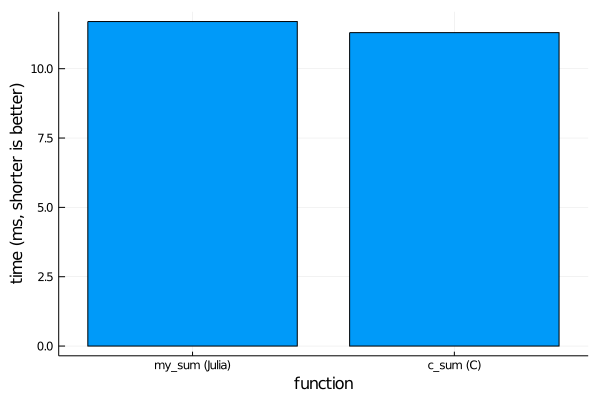

In [61]:
results = [
    "my_sum (Julia)" => 11.7,
    "c_sum (C)" => 11.3
]

bar(first.(results), last.(results), xlabel="function", ylabel="time (ms, shorter is better)", legend=nothing)

Our naive Julia code is just as fast as our naive C code! 

Is that as fast as we can go? What about Julia's built-in `sum()` function:

In [62]:
@btime sum($data)

  5.377 ms (0 allocations: 0 bytes)


4.998996907718867e6

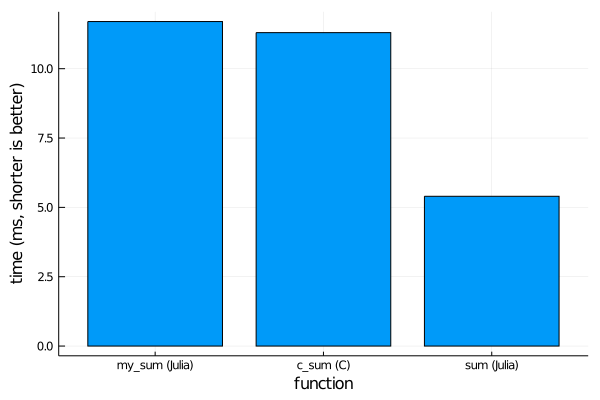

In [63]:
results = [
    "my_sum (Julia)" => 11.7,
    "c_sum (C)" => 11.3,
    "sum (Julia)" => 5.4,
]

bar(first.(results), last.(results), xlabel="function", ylabel="time (ms, shorter is better)", legend=nothing)

What's going on? Is the `sum()` function using some built-in behavior we don't have access to?

Nope--we can achieve that result easily with a few modifications:

In [64]:
function my_fast_sum(x)
    result = zero(eltype(x))
    
    # `@inbounds` is a macro which disables all bounds checking within a given block. 
    #
    # `@simd` enables additional vector operations by indicating that it is OK to potentially
    # evaluate the loop out-of-order. 
    @inbounds @simd for element in x
        result += element
    end
    result
end

my_fast_sum (generic function with 1 method)

In [65]:
@btime my_fast_sum($data)

  5.332 ms (0 allocations: 0 bytes)


4.998996907718901e6

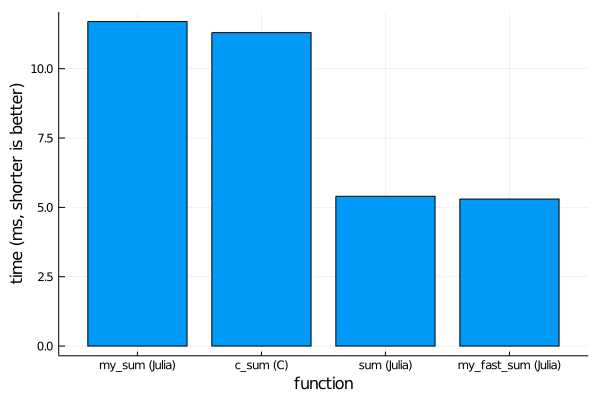

In [66]:
results = [
    "my_sum (Julia)" => 11.7,
    "c_sum (C)" => 11.3,
    "sum (Julia)" => 5.4,
    "my_fast_sum (Julia)" => 5.3,
]

bar(first.(results), last.(results), xlabel="function", ylabel="time (ms, shorter is better)", legend=nothing)

With some pretty simple changes, we were able to create a pure-Julia function which is twice as fast as our naive C function while still being clear and completely generic:

In [67]:
my_fast_sum([1, 2.5, π])

6.641592653589793

Just for reference, let's compare with Python. It's easy to call Python code from Julia too--we just need the `PyCall` package:

In [68]:
using PyCall

In [69]:
py_math = pyimport("math")
py_math.sin(1.0)

0.8414709848078965

Just as we did with C, we can quickly define a Python sum function without leaving Julia:

In [70]:
# The PyCall package lets us define python functions directly from Julia:

py"""
def mysum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

# mysum_py is a reference to the Python mysum function
py_sum = py"""mysum"""o

PyObject <function mysum at 0x7f2250f9df28>

Let's make sure we're getting similar answers everywhere:

In [71]:
py_sum(data) ≈ c_sum(data) ≈ sum(data) ≈ my_sum(data) ≈ my_fast_sum(data)

true

In [72]:
@btime py_sum($data)

  724.217 ms (7 allocations: 352 bytes)


4.998996907719521e6

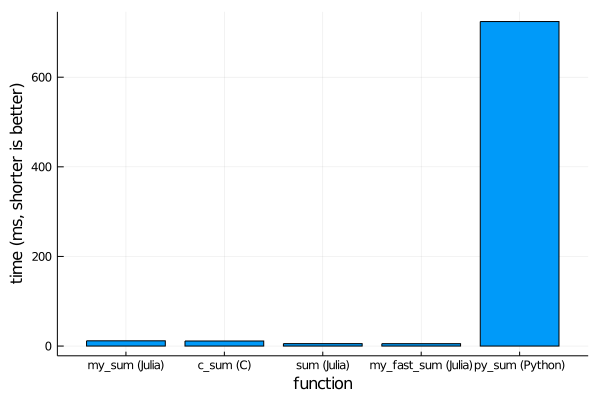

In [74]:
results = [
    "my_sum (Julia)" => 11.7,
    "c_sum (C)" => 11.3,
    "sum (Julia)" => 5.4,
    "my_fast_sum (Julia)" => 5.3,
    "py_sum (Python)" => 724.2,
]

bar(first.(results), last.(results), xlabel="function", ylabel="time (ms, shorter is better)", legend=nothing)

### What about Numpy or Cython?

* Of course, there are faster ways to sum a vector of `double`s in Python than a `for` loop. 
* `numpy.sum()` is just as fast as Julia's `sum()` for large vectors...
* ...but there are some caveats:
  * NumPy is only efficient for a pre-determined set of numeric types. 
  * NumPy cannot be extended without switching into an entirely different programming language, build system, and code environment. 
  * So, if `numpy.sum()` happens to cover the cases you actually need, then go for it!
  * But if you want to be able to write efficient code that does not happen to cover the specific set of functions and types in NumPy, then you need Julia. 

In [75]:
struct Point{T}
    x::T
    y::T
end

function Base.zero(::Type{Point{T}}) where {T} 
    Point{T}(zero(T), zero(T))
end
    
Base.:+(p1::Point, p2::Point) = Point(p1.x + p2.x, p1.y + p2.y)

points = [Point(rand(), rand()) for _ in 1:10^7];

In [76]:
@btime my_fast_sum($points)

  15.001 ms (0 allocations: 0 bytes)


Point{Float64}(5.000181181696696e6, 5.000916078448208e6)

In [77]:
@code_native my_fast_sum(points)

	.text
; ┌ @ In[64]:2 within `my_fast_sum'
	movq	%rdi, %rax
; │ @ In[64]:8 within `my_fast_sum'
; │┌ @ simdloop.jl:71 within `macro expansion'
; ││┌ @ simdloop.jl:51 within `simd_inner_length'
; │││┌ @ array.jl:221 within `length'
	movq	8(%rsi), %rcx
; ││└└
; ││ @ simdloop.jl:72 within `macro expansion'
; ││┌ @ int.jl:49 within `<'
	testq	%rcx, %rcx
; ││└
	jle	L51
	movq	(%rsi), %rdx
	vxorpd	%xmm0, %xmm0, %xmm0
	nopw	%cs:(%rax,%rax)
	nopl	(%rax)
; ││ @ simdloop.jl:77 within `macro expansion' @ In[64]:9
; ││┌ @ In[75]:10 within `+' @ float.jl:401
L32:
	vaddpd	(%rdx), %xmm0, %xmm0
; ││└
; ││ @ simdloop.jl:75 within `macro expansion'
; ││┌ @ int.jl:49 within `<'
	addq	$16, %rdx
	addq	$-1, %rcx
; ││└
	jne	L32
; │└
; │ @ In[64]:11 within `my_fast_sum'
	vmovupd	%xmm0, (%rax)
	retq
L51:
	vxorps	%xmm0, %xmm0, %xmm0
; │ @ In[64]:11 within `my_fast_sum'
	vmovups	%xmm0, (%rax)
	retq
	nopl	(%rax)
; └


# Bonus Features of Julia

## Asynchronous Tasks

Julia supports asynchronous cooperative tasks, with `libuv` providing the backend. These tasks are great for handling operations like IO or network requests:

In [78]:
using HTTP: request

In [83]:
for i in 1:5
    @async begin
        println("starting request $i")
        r = request("GET", "https://jsonplaceholder.typicode.com/posts/$i")
        println("got response $i with status $(r.status)")
    end
end
        

starting request 1
starting request 2
starting request 3
starting request 4
starting request 5
got response 2 with status 200
got response 4 with status 200
got response 3 with status 200
got response 1 with status 200
got response 5 with status 200


## Multi-Threading


Julia also supports parallel and distributed computing (see https://docs.julialang.org/en/v1/manual/parallel-computing/ for more). In addition, Julia 1.3 implemented a new feature, the Parallel Task Run-Time (PATR), which allows for *composable* multi-threading. It is now possible for a parallelized Julia function to call other parallelized code without over-subsubscribing the available processors. See 
https://julialang.org/blog/2019/07/multithreading/ for more. 

In [84]:
using Base.Threads: @spawn


function fib(n::Int)
    if n < 2
        return n
    end
    # `@spawn` creates a new parallel task. Tasks are lightweight and can be
    # created at will. The Julia Parallel Task Run-Time handles scheduling the
    # tasks to native threads in a depth first manner. That means that you can
    # write parallel code which calls other parallel code without over-subscribing
    # your available processors. 
    t = @spawn fib(n - 2)
    return fib(n - 1) + fetch(t)
end 

fib (generic function with 1 method)

## No Implicit Copying

Values are never copied unless you intentionally copy or convert them. That means that functions can mutate their input arguments to efficiently do work in-place:

In [85]:
"""
Invert the sign of the vector `x`, operating in-place to avoid any memory allocation.
"""
function invert!(x::AbstractVector)
    for i in eachindex(x)
        x[i] = -x[i]
    end
end

invert!

Note: the `!` in the function name is just a convention: it signals to readers of the code
that the input argument `x` will be modified.

In [86]:
x = [1, 2, 3]
invert!(x)
x

3-element Array{Int64,1}:
 -1
 -2
 -3

In [87]:
@btime invert!($x)

  4.133 ns (0 allocations: 0 bytes)


## Anything Can Be a Value

Julia has no special rules about what can or cannot be assigned to a variable or passed to a function. 

### Functions are Values

A Julia function is a value like any other, so passing functions around and implementing higher-order functions is trivial:

In [88]:
"""
map_reduce: apply `operator` to each element in `array` and reduce pairwise via `reduction`
"""
function map_reduce(operator, reduction, array, initial_value)
    result = initial_value
    for item in array
        result = reduction(result, operator(item))
    end
    result
end

map_reduce

In [89]:
map_reduce(sin, +, [1, 2, 3, 4], 0)

1.1350859243855171

We can define `sum` in terms of `map_reduce`:

In [90]:
fancy_sum(x) = map_reduce(identity, +, x, zero(eltype(x)))

fancy_sum (generic function with 1 method)

The performance is just as good as our hand-written `sum` loop:

In [91]:
@btime fancy_sum($data)

  11.762 ms (0 allocations: 0 bytes)


4.998996907719521e6

To get all the way down to 5ms, we'd need to apply the same `@inbounds` and `@simd` annotations.  

### Types are Values

Types can also be passed around as values and bound to variables with no special rules. This makes implementing factories or constructors easy:

In [92]:
function empty_matrix(T::Type, rows::Integer, cols::Integer)
    zeros(T, rows, cols)
end

empty_matrix (generic function with 1 method)

In [93]:
empty_matrix(Int, 3, 3)

3×3 Array{Int64,2}:
 0  0  0
 0  0  0
 0  0  0

In [94]:
empty_matrix(Point{Float64}, 3, 3)

3×3 Array{Point{Float64},2}:
 Point{Float64}(0.0, 0.0)  Point{Float64}(0.0, 0.0)  Point{Float64}(0.0, 0.0)
 Point{Float64}(0.0, 0.0)  Point{Float64}(0.0, 0.0)  Point{Float64}(0.0, 0.0)
 Point{Float64}(0.0, 0.0)  Point{Float64}(0.0, 0.0)  Point{Float64}(0.0, 0.0)

### Expressions are Values

Even the expressions that representing Julia code are represented as values in Julia. You can create an expression with the `:()` operator, and you can inspect it just like any other object. 

In [95]:
expr = :(1 + 2)

:(1 + 2)

An expression has a `head` indicating what type of expression it is and zero or more `args`:

In [96]:
expr.head

:call

In [97]:
expr.args

3-element Array{Any,1}:
  :+
 1
 2

## Metaprogramming

Since expressions are just values, we can easily write functions to manipulate them:

In [98]:
switch_to_subtraction!(x::Any) = nothing

"""
Change all `+` function calls to `-` function calls. 

<sarcasm>
Great for fixing sign errors in your code!
</sarcasm>
"""
function switch_to_subtraction!(ex::Expr)
    if ex.head == :call && ex.args[1] == :(+)
        ex.args[1] = :(-)
    end
    for i in 2:length(ex.args)
        switch_to_subtraction!(ex.args[i])
    end
end

switch_to_subtraction!

In [99]:
expr = :((1 + 2) * (3 + 4) * sqrt(2))

:((1 + 2) * (3 + 4) * sqrt(2))

In [100]:
switch_to_subtraction!(expr)

expr

:((1 - 2) * (3 - 4) * sqrt(2))

### Macros

A macro is written just like a normal Julia function. The difference is that a macro operates on the *expression* itself, not on its value:

In [101]:
"""
Modify a given expression, replacing all string literals with "cat"
"""
macro more_cats(expr)
    for i in eachindex(expr.args)
        if expr.args[i] isa String
            expr.args[i] = "cat"
        end
    end
    return esc(expr)
end

@more_cats

Macros are always called with the `@` prefix in Julia:

In [102]:
@more_cats println("hello world")

cat


`@macroexpand` shows the code that another macro will generate:

In [103]:
@macroexpand @more_cats println("hello world")

:(println("cat"))

### Actually Useful Julia Macros

`@show` : print out the *name* of a variable and its value. Great for quick debugging:

In [104]:
x = 5
@show x

x = 5


5

`@time` measure the elapsed time of an expression and return the result of that expression:

In [105]:
@time sqrt(big(π))

  0.000074 seconds (6 allocations: 464 bytes)


1.772453850905516027298167483341145182797549456122387128213807789852911284591025

`@showprogress`: Time each iteration of a loop and estimate how much longer it will take to finish:

In [106]:
using ProgressMeter: @showprogress

In [107]:
@showprogress for i in 1:100
    sum(rand(10^7))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


# What's Hard to Do in Julia?

What is the compiler team working on making better? https://discourse.julialang.org/t/compiler-work-priorities/17623

What are some subtle problems that the Julia team would like to fix?

[![What's bad about Julia talk](img/bad_about_julia.png)](https://www.youtube.com/watch?v=TPuJsgyu87U)



## Compiler Latency

* The JIT compiler runs each time it sees a function being called with a new input type. 
* That makes the first call to every function slow, since you have to wait for the JIT.
  * This makes Julia awkward to use for things like shell scripts or AWS lambda

## Static Compilation

* To avoid the JIT lag, you can compile a Julia package to a standalone executable using [PackageCompiler.jl](https://github.com/JuliaLang/PackageCompiler.jl), but:
    * This workflow is pretty new, and you may run into interesting bugs
    * The resulting libraries tend to be quite large

## Embedded Computing

* It can be hard to run Julia on memory-limited systems, since you need the compiler living alongside your code. 
* Static compilation can help, but this isn't a well-developed workflow yet.

## Static Analysis

* There are some linting tools for Julia (like the `vscode-julia` extension for Visual Studio Code), but they are not as mature as languages like Python, C, Java, etc.
* Static analysis of Julia is harder, since the language itself is dynamically typed. 
  * To be fair, static analysis of C++ is [undecidable](https://blog.reverberate.org/2013/08/parsing-c-is-literally-undecidable.html) but we still have tools that do a pretty good job most of the time. 

# Useful Julia Tools

## Juno IDE

https://junolab.org/

* Built-in debugger and profiler support
* Inline evaluation of expressions
* Docstring lookup and autocomplete


<img src="img/juno.png" width="700px"></img>

## Julia-VSCode

https://github.com/julia-vscode/julia-vscode

* Code highlighting, snippets, linting, and completions
* Integrated plot and table viewers
* General extension support via the VSCode language server

<img src="img/vscode.png" width="700px"></img>

## Flux.jl

https://fluxml.ai/Flux.jl/stable/

* Flexible library for machine learning built entirely in Julia
* Feed-forward and recurrent neural nets
* Gradients via automatic differentiation
* GPU support via CuArrays.jl

```julia
m = Chain(
  Dense(784, 32, σ),
  Dense(32, 10), softmax
)

loss(x, y) = Flux.mse(m(x), y)
ps = Flux.params(m)

for i in 1:num_training_iters
    Flux.train!(loss, ps, data, opt)
end
```

## DifferentialEquations.jl

https://github.com/SciML/DifferentialEquations.jl

* {stochastic | deterministic | ordinary | partial} differential equations
* Automatic differentiation and sparsity detection
* GPU support
* Sensitivity analysis and parameter estimation
* Access to pure-Julia solvers and existing C and Fortran solvers


<img src="img/DifferentialEquations_Example.png" width="500px"></img>

## DataFrames.jl

https://github.com/JuliaData/DataFrames.jl

* In-memory tabular data
* Joining, indexing, grouping, and split-apply-combine

```julia
julia> using DataFrames

julia> df = DataFrame(A = 1:4, B = ["M", "F", "F", "M"])
4×2 DataFrame
│ Row │ A     │ B      │
│     │ Int64 │ String │
├─────┼───────┼────────┤
│ 1   │ 1     │ M      │
│ 2   │ 2     │ F      │
│ 3   │ 3     │ F      │
│ 4   │ 4     │ M      │
```

## JuMP.jl

https://github.com/JuliaOpt/JuMP.jl

* Continuous and discrete optimization
* Support for a wide variety of free and commercial solvers
* Efficient high-level language for mathematical programming


Example: Solving a simple model-predictive control problem as a quadratic program ([source](https://github.com/rdeits/DynamicWalking2018.jl/blob/master/notebooks/6.%20Optimization%20with%20JuMP.ipynb)):

[![demo of a simple model-predictive control problem](img/mpc.gif)](https://github.com/rdeits/DynamicWalking2018.jl/blob/master/notebooks/6.%20Optimization%20with%20JuMP.ipynb)



### Cassette.jl

https://www.youtube.com/watch?v=_E2zEzNEy-8

"Overdub" Julia code: 

* Hook into the compiler to dynamically modify the behavior of existing functions in a given *context*
* Building block for debuggers, automatic differentation, and more.

<img src="img/cassette-logo.png" width="600px"/>

# Where To Go Next?

* Download Julia from https://julialang.org/
* Check out the manual at https://docs.julialang.org/en/v1/
* Ask questions on [discourse](https://discourse.julialang.org/) and [slack](https://slackinvite.julialang.org/)
* Find interesting packages on [juliahub](https://juliahub.com/ui/Home)

![triangulated background](img/julia-triangle-background.svg)

[Logo by Cormullion and David P. Saunders](https://nbviewer.jupyter.org/github/dpsanders/JuliaCon2019_tshirt/blob/master/penroseiana.ipynb)